In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from itertools import product
from keras.preprocessing.sequence import TimeseriesGenerator

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
model = load_model('trained_model_2.h5')
scaler= joblib.load('scaler.pkl')
df = pd.read_csv('./rawData/data_prueba_Forecasting.csv')
df=df.drop(['Unnamed: 0'], axis=1)


In [3]:
df

,Formato,Subformato,Tienda,Producto,id_fec_diaria,Venta,Precio,Venta_aa,Precio_aa
0,Super,Basico,1,369772,2021-08-01,7.0,17.168571,5.0,21.063200
1,Super,Basico,1,369772,2021-08-02,6.0,17.141667,3.0,21.388667
2,Super,Basico,1,369772,2021-08-03,5.0,17.136000,5.0,21.376199
3,Super,Basico,1,369772,2021-08-04,4.0,16.995000,3.0,21.360367
4,Super,Basico,1,369772,2021-08-05,1.0,17.240000,1.0,21.397100
...,...,...,...,...,...,...,...,...,...
426372,Super,Plus,1,2098857,2021-10-27,8.0,27.003750,16.0,20.083056
426373,Super,Plus,1,2098857,2021-10-28,18.0,26.911667,22.0,20.121114
426374,Super,Plus,1,2098857,2021-10-29,13.0,24.463077,20.0,18.967170
426375,Super,Plus,1,2098857,2021-10-30,17.0,25.404118,37.0,18.206573


In [4]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 15, 64)            19456     
                                                                 
 lstm_2 (LSTM)               (None, 28)                10416     
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 29,901
Trainable params: 29,901
Non-trainable params: 0
_________________________________________________________________


In [5]:
df.head()

,Formato,Subformato,Tienda,Producto,id_fec_diaria,Venta,Precio,Venta_aa,Precio_aa
0,Super,Basico,1,369772,2021-08-01,7.0,17.168571,5.0,21.063200
1,Super,Basico,1,369772,2021-08-02,6.0,17.141667,3.0,21.388667
2,Super,Basico,1,369772,2021-08-03,5.0,17.136000,5.0,21.376199
3,Super,Basico,1,369772,2021-08-04,4.0,16.995000,3.0,21.360367
4,Super,Basico,1,369772,2021-08-05,1.0,17.240000,1.0,21.397100


In [6]:
df.shape

(426377, 9)

In [7]:
df['id_fec_diaria'] = pd.to_datetime(df['id_fec_diaria']) 
def fill_missing(values):
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if pd.isnull(values[row][col]):
                values[row,col] = values[row-one_day,col]
fill_missing(df.values)
dfCopy = df.copy()
dfCopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426377 entries, 0 to 426376
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Formato        426377 non-null  object        
 1   Subformato     426377 non-null  object        
 2   Tienda         426377 non-null  int64         
 3   Producto       426377 non-null  int64         
 4   id_fec_diaria  426377 non-null  datetime64[ns]
 5   Venta          426377 non-null  float64       
 6   Precio         426377 non-null  float64       
 7   Venta_aa       426377 non-null  float64       
 8   Precio_aa      426377 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 29.3+ MB


In [8]:
def generate_dates(year, month):
    start_date = pd.Timestamp(year=year, month=month, day=1)
    end_date = start_date + pd.offsets.MonthEnd(0)
    dates = pd.date_range(start_date, end_date, freq='D')
    return dates

year = 2021
month = 11

dates_series = generate_dates(year, month)
print(dates_series)


DatetimeIndex(['2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
               '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08',
               '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-15', '2021-11-16',
               '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-20',
               '2021-11-21', '2021-11-22', '2021-11-23', '2021-11-24',
               '2021-11-25', '2021-11-26', '2021-11-27', '2021-11-28',
               '2021-11-29', '2021-11-30'],
              dtype='datetime64[ns]', freq='D')


In [9]:
def extract_unique_column_elements(dataframe, column_name):
    unique_elements = dataframe[column_name].unique()
    unique_series = pd.Series(unique_elements)
    return unique_series

In [10]:
unique_formato_series = extract_unique_column_elements(df, 'Formato')
print(unique_formato_series)

0    Super
1    Hiper
dtype: object


In [11]:
unique_subformato_series = extract_unique_column_elements(df, 'Subformato')
print(unique_subformato_series)

0        Basico
1          Plus
2    Intermedio
dtype: object


In [12]:
unique_Tienda_series = extract_unique_column_elements(df, 'Tienda')
print(unique_Tienda_series)

0    1
dtype: int64


In [13]:
unique_Producto_series = extract_unique_column_elements(df, 'Producto')
print(unique_Producto_series)

0         369772
1         303923
2        1791075
3        1720010
4        1224404
          ...   
2400      378759
2401    11442635
2402    11400275
2403    11025261
2404     1155395
Length: 2405, dtype: int64


In [14]:
pairs  = list(product(unique_formato_series, unique_subformato_series, unique_Tienda_series, dates_series, unique_Producto_series))


In [15]:
result_df = pd.DataFrame(pairs, columns = ['Formato', 'Subformato', 'Tienda', 'id_fec_diaria', 'Producto'])

In [16]:
result_df

,Formato,Subformato,Tienda,id_fec_diaria,Producto
0,Super,Basico,1,2021-11-01,369772
1,Super,Basico,1,2021-11-01,303923
2,Super,Basico,1,2021-11-01,1791075
3,Super,Basico,1,2021-11-01,1720010
4,Super,Basico,1,2021-11-01,1224404
...,...,...,...,...,...
432895,Hiper,Intermedio,1,2021-11-30,378759
432896,Hiper,Intermedio,1,2021-11-30,11442635
432897,Hiper,Intermedio,1,2021-11-30,11400275
432898,Hiper,Intermedio,1,2021-11-30,11025261


In [17]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432900 entries, 0 to 432899
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Formato        432900 non-null  object        
 1   Subformato     432900 non-null  object        
 2   Tienda         432900 non-null  int64         
 3   id_fec_diaria  432900 non-null  datetime64[ns]
 4   Producto       432900 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 16.5+ MB


In [18]:
list_months = []
list_days = []
list_years = []
new_total_rows = result_df.shape[0]

for i in range(new_total_rows):
    list_months.append(result_df['id_fec_diaria'][i].month)
    
for j in range(new_total_rows):
    list_days.append(result_df['id_fec_diaria'][j].day)
    
for k in range(new_total_rows):
    list_years.append(result_df['id_fec_diaria'][k].year)

list_months = pd.Series(list_months)
list_days = pd.Series(list_days)
list_years = pd.Series(list_years)

result_df['Mes'] = list_months
result_df['Day'] = list_days
result_df['Year'] = list_years

result_df = pd.get_dummies(result_df,
                                            columns = ['Formato', 'Subformato'], drop_first=False)


result_df['DayOfWeek'] = result_df['id_fec_diaria'].dt.dayofweek

In [19]:
result_df

,Tienda,id_fec_diaria,Producto,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek
0,1,2021-11-01,369772,11,1,2021,0,1,1,0,0,0
1,1,2021-11-01,303923,11,1,2021,0,1,1,0,0,0
2,1,2021-11-01,1791075,11,1,2021,0,1,1,0,0,0
3,1,2021-11-01,1720010,11,1,2021,0,1,1,0,0,0
4,1,2021-11-01,1224404,11,1,2021,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
432895,1,2021-11-30,378759,11,30,2021,1,0,0,1,0,1
432896,1,2021-11-30,11442635,11,30,2021,1,0,0,1,0,1
432897,1,2021-11-30,11400275,11,30,2021,1,0,0,1,0,1
432898,1,2021-11-30,11025261,11,30,2021,1,0,0,1,0,1


In [20]:
result_df.shape

(432900, 12)

In [21]:
columnsToScale = ['Tienda', 'Producto', 'Mes', 'Day', 'Year', 'Formato_Hiper', 'Formato_Super', 'Subformato_Basico', 'Subformato_Intermedio', 'Subformato_Plus', 'DayOfWeek']

sequence_length = 30

batch_size = 64

num_features = len(columnsToScale)


featureDataFrame_testing = result_df[columnsToScale]

x_testing = result_df[columnsToScale]

x_testing_scaled = scaler.fit_transform(x_testing)

test_sequence_generator = TimeseriesGenerator(x_testing_scaled, targets=x_testing_scaled, length=sequence_length, batch_size=batch_size)


In [22]:
predictions = model.predict(test_sequence_generator)



6764/6764 [==============================] - 56s 8ms/step


In [23]:
predictions

array([[0.00201817],
       [0.00208789],
       [0.00173076],
       ...,
       [0.00363411],
       [0.00269655],
       [0.00310455]], dtype=float32)

In [24]:
predictions.shape

(432870, 1)

In [25]:
predictions_reshaped = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_testing_scaled[:,1:][sequence_length:])], axis=1)

In [37]:
predictions_reshaped

,0,0,1,2,3,4,5,6,7,8,9
0,0.002018,0.051710,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000
1,0.002088,0.088182,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000
2,0.001731,0.189739,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000
3,0.001978,0.091401,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000
4,0.001742,0.187387,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
432865,0.003504,0.032831,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.166667
432866,0.004191,0.992149,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.166667
432867,0.003634,0.988476,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.166667
432868,0.002697,0.955960,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.166667


In [26]:
reverse_transformation = scaler.inverse_transform(predictions_reshaped)

In [39]:
reverse_transformation.shape

(432870, 11)

In [27]:
reverse_transformation_final = featureDataFrame_testing[predictions.shape[0]* - 1:]

In [28]:
reverse_transformation_final['Predictions'] = reverse_transformation[:,0]

C:\Users\alan_\AppData\Local\Temp\ipykernel_51528\3118658882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reverse_transformation_final['Predictions'] = reverse_transformation[:,0]


In [29]:
reverse_transformation_final['id_fec_diaria'] = result_df['id_fec_diaria']

C:\Users\alan_\AppData\Local\Temp\ipykernel_51528\2200927985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reverse_transformation_final['id_fec_diaria'] = result_df['id_fec_diaria']


In [30]:
reverse_transformation_final

,Tienda,Producto,Mes,Day,Year,Formato_Hiper,Formato_Super,Subformato_Basico,Subformato_Intermedio,Subformato_Plus,DayOfWeek,Predictions,id_fec_diaria
30,1,596485,11,1,2021,0,1,1,0,0,0,1.002018,2021-11-01
31,1,1017128,11,1,2021,0,1,1,0,0,0,1.002088,2021-11-01
32,1,2188382,11,1,2021,0,1,1,0,0,0,1.001731,2021-11-01
33,1,1054247,11,1,2021,0,1,1,0,0,0,1.001978,2021-11-01
34,1,2161265,11,1,2021,0,1,1,0,0,0,1.001742,2021-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432895,1,378759,11,30,2021,1,0,0,1,0,1,1.003504,2021-11-30
432896,1,11442635,11,30,2021,1,0,0,1,0,1,1.004191,2021-11-30
432897,1,11400275,11,30,2021,1,0,0,1,0,1,1.003634,2021-11-30
432898,1,11025261,11,30,2021,1,0,0,1,0,1,1.002697,2021-11-30


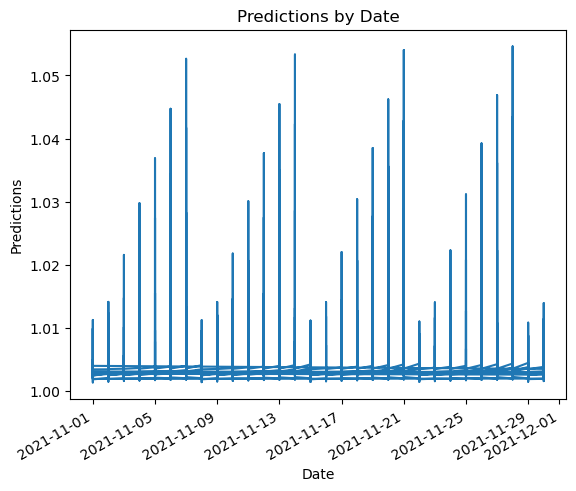

In [36]:
data_for_plot = reverse_transformation_final.copy()
data_for_plot.set_index('id_fec_diaria', inplace=True)

plt.plot(reverse_transformation_final['id_fec_diaria'], reverse_transformation_final['Predictions'])

plt.title('Predictions by Date')

plt.xticks(rotation=30, ha='right')

plt.xlabel('Date')
plt.ylabel('Predictions')

plt.show()


In [33]:
reverse_transformation_final.to_csv('./rawData/newNoviembre2021.csv')